In [54]:
# helper functions

def prettyPrint(procTestLists):
    """
        Pretty-prints a list of lists of test assignments
    """
    pWidth = 1+len(str(len(procTestLists)))
    tWidth = 1+len(str(max(e for l in procTestLists for e in l)))
    for pIdx, tList in enumerate(procTestLists):        
        print("proc {:>{pWidth}} > {}".format(pIdx, " ".join("{:>{tWidth}}".format(t, tWidth=tWidth) for t in tList),
              pWidth=pWidth))

# The "Long Pole" Effect in Gradle's Test Execution

When we assign a number of tests (with different runtimes) to multiple processors for parallel execution, the overall test runtime is that of the processor with the highest load as measured by the summed test execution times. Ideally, this approaches the quotient between total test runtime and number of processors. However, when one processor is assigned an unproportionally high load of tests, the overall runtime will depend on this processor: It will have to continue to work off tasks after all other processors have finshed, thus becoming the "long pole" in the runtime.

This phenomenon has been [discussed for Gradle's parallel test execution](https://github.com/gradle/gradle/issues/2669). An important point here is that Gradle will not split up a test class for parallelization, so the smallest unit which we distribute is the test class; if we have classes containing long(er)-running integration-like tests, this increases the potential for running into the "long pole" problem.

## Scheduling

Gradle currently uses a round-robin approach to evenly pre-allocate test classes to multiple processors. This distribution is based solely on the order of the classes; it does not take into account size or other information:

In [55]:
def roundRobin(tests, procCount):
    """ 
    Takes a list of test items and distributes them in a straight-forward round-robin
    fashion amongst the number of given processors.
    :return: a list of `procCount` lists L1 ...Lx, where each Li denotes the tests assigned
             to processor #x.
    """
    procs = [[] for _i in range(procCount)]

    for tIdx, test in enumerate(tests):
        pos = tIdx % procCount
        procs[pos].append(test)
    return procs

If we have 20 tests and 5 processors, they would be distributed as follows:

In [56]:
prettyPrint(roundRobin(range(20), 5))

proc  0 >   0   5  10  15
proc  1 >   1   6  11  16
proc  2 >   2   7  12  17
proc  3 >   3   8  13  18
proc  4 >   4   9  14  19


 So, if tests **0**, **5**, and **10** happen to take very long, processor **0** would become the long pole in this scenario.

## Experiments

Using generated test runtime distributions, we can simulate how they influence the overall runtime. In Gradle's own `build.gradle.kts`, we can modify the `allprojects` configuration to make the test classes log their runtime:

```kotlin
tasks.withType<Test> {
        outputs.upToDateWhen { false }
        addTestListener(object : TestListener {
            override fun beforeSuite(suite: TestDescriptor) {}
            override fun beforeTest(testDescriptor: TestDescriptor) {}
            override fun afterTest(testDescriptor: TestDescriptor, result: TestResult) {
            }
            override fun afterSuite(suite: TestDescriptor, result: TestResult) {
                val duration = result.endTime - result.startTime
                println(">>> $suite\t${duration}")
            }
        })
    }
```

The resulting times for a few runs are collected in file://./gradle_test_stats. Sort them by runtime and averaging over the runs gives an impression of the test classes' runtime distribution:

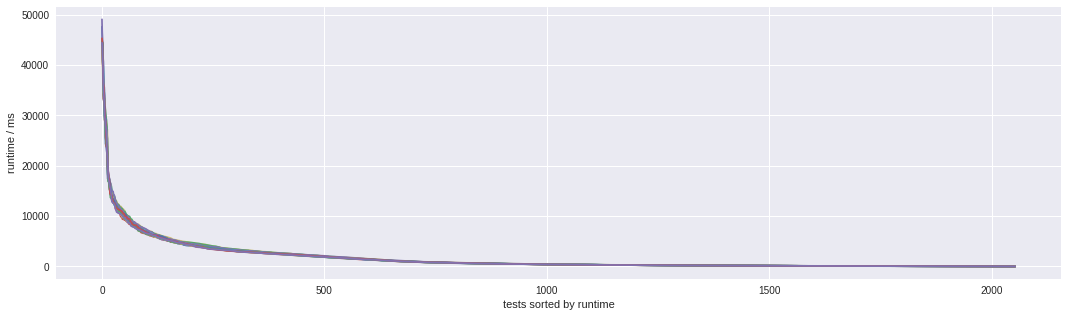

Evaluated 16 overall test executions with 2053 tests each:
On average, the longest class runtime was 45.06 seconds, the shortest 1.44 milliseconds, with a median of {median:.2f} milliseconds.


In [13]:
import pathlib as pl
from matplotlib import pyplot as plt
plt.style.use('seaborn')

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]

timesFiles = pl.Path("gradle_test_stats").glob("*.times")
sums, seriesCount = None, 0
for tfName in timesFiles:
    with open(tfName) as tff:
        vals = sorted((int(l.strip()) for l in tff), reverse=True)
        sums = vals if sums is None else [v+s for v,s in zip(vals, sums)]
        seriesCount += 1
    plt.plot(vals)
plt.xlabel("tests sorted by runtime")
plt.ylabel("runtime / ms")
plt.show()

import statistics as stats
runtimes = [s/seriesCount for s in sums]
longest, median, shortest = runtimes[0], stats.median(runtimes), runtimes[-1]
print(f"Evaluated {seriesCount} overall test executions with {len(sums)} tests each:")
print(f"On average, the longest class runtime was {longest/1000:.2f} seconds, the shortest {shortest:.2f} milliseconds, "
      "with a median of {median:.2f} milliseconds.")

In [ ]:
At the time of writing, there were 2053 test classes in Gradle. The distribution is 

## Shifting Round Robin

In [57]:
def shiftingRoundRobin(tests, procCount):
    """ 
    Takes a list of test items and distributes them in a shifting round-robin
    fashion amongst the number of given processors.
    :return: a list of `procCount` lists L1 ...Lx, where each Li denotes the tests assigned
             to processor #x.
    """
    
    procs = [[] for _i in range(procCount)]

    for tIdx, test in enumerate(tests):
        shift = (tIdx//procCount)%procCount
        pos = (shift + tIdx) % procCount
        procs[pos].append(test)
    return procs

In [58]:
res = shiftingRoundRobin(range(15), 3)
prettyPr(res)

proc  0 >   0   5   7   9  14
proc  1 >   1   3   8  10  12
proc  2 >   2   4   6  11  13
